# Part 6: Predictions for other categories

Do note that you have to use an environment with Tensorflow installed to run this notebook.

In this section, I will be using the selected model to predict the premium price for other categories. As categories B and E are also mainly used for cars, I will generate a prediction for these 2 categories.

In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import (
    train_test_split,
)

from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
# Importing dataset
coe = pd.read_csv('../data/coe_cleaned.csv')

In [3]:
# Creating a function to perform train test split
def manual_train_test_split(df):
    training_size = int(len(df)*0.8)
    test_size = len(df) - training_size
    train_data, test_data = df[0:training_size, :], df[training_size:len(df),:1]
    return train_data, test_data

In [4]:
# Creating a function to split train test data to X and y
def split_Xy(df, time_step=1):
    X = [] 
    y = []
    for i in range(len(df) - time_step):
        X_data = df[i:(i + time_step), 0]
        X.append(X_data)
        y.append(df[i + time_step, 0])
    return np.array(X), np.array(y)

In [5]:
# Creating a function to add time steps to the inputs
def preprocessing(df, time_step):
    train_data, test_data = manual_train_test_split(df)
    X_train, y_train = split_Xy(train_data, time_step)
    X_test, y_test = split_Xy(test_data, time_step)
    return X_train, y_train, X_test, y_test

In [6]:
# Creating a function to generate the model
def generate_gru_model(X_train, y_train, X_test, y_test, scaler, time_step):
    
    X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
    
    model_gru = Sequential()
    model_gru.add(GRU(
        16,
        input_shape=(time_step, 1),
        return_sequences=True,
    ))

    model_gru.add(GRU(
        16,
        return_sequences=True,
    ))

    model_gru.add(GRU(
        16,
        return_sequences=True,
    ))

    model_gru.add(GRU(
        16,
        return_sequences=False,
    ))

    model_gru.add(Dense(4, activation='relu'))
    model_gru.add(Dense(1,))
    
    model_gru.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
    )
    
    model_gru.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    batch_size=16,
    epochs=50
    )
    
    train_predict = model_gru.predict(X_train)
    train_predict = scaler.inverse_transform(train_predict)
    
    test_predict = model_gru.predict(X_test)
    test_predict = scaler.inverse_transform(test_predict)
    
    print(mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict))
    
    return train_predict, test_predict

In [7]:
# Creating a function to plot the predictions after generating the model
def plot_predictions(df, train_prediction, test_prediction, time_step, scaler):
    trainPlot = np.empty_like(df)
    trainPlot[:, :] = np.nan
    trainPlot[time_step:len(train_prediction) + time_step, :] = train_prediction

    testPlot = np.empty_like(df)
    testPlot[:, :] = np.nan
    testPlot[len(train_prediction) + (time_step * 2): len(df), :] = test_prediction

    plt.figure(figsize=(12,9), dpi=200)
    plt.plot(scaler.inverse_transform(df))
    plt.plot(trainPlot)
    plt.plot(testPlot)
    plt.show()

In [16]:
def success_rate(actual_premium, predicted_premium):
    successful_bids = []
    if type(actual_premium) != np.ndarray:
        actual_reset = actual_premium.reset_index(drop=True)
        for i in range(len(predicted_premium)):
            if predicted_premium[i] >= actual_reset[i]:
                 successful_bids.append(actual_reset[i])
    else:
        for i in range(len(predicted_premium)):
            if predicted_premium[i] >= actual_premium[i]:
                 successful_bids.append(actual_premium[i])
    return round((len(successful_bids) / len(actual_premium)) * 100, 1), len(successful_bids), len(actual_premium)

In [8]:
def success_with_addition(actual_premium, predicted_premium, success_rate):
    current_rate = 0
    addition = 0
    while current_rate < success_rate:
        successful_bids = []
        new_preds = predicted_premium + addition
        for i in range(len(new_preds)):
            if new_preds[i] >= actual_premium[i]:
                successful_bids.append(new_preds[i])
        current_rate = (len(successful_bids) / len(actual_premium))
        addition += 1
    return addition, current_rate

## Category B

In [9]:
coe_cat_b = coe[coe['category'] == 'cat_b']
coe_cat_b = coe_cat_b.set_index('new_date')
coe_cat_b.sort_index(inplace=True)

In [10]:
# Scaling the data
mm_scaler = MinMaxScaler()
df1 = mm_scaler.fit_transform(np.array(coe_cat_b['premium']).reshape(-1, 1))

In [11]:
# Creating X and y for both training and test data with 18 timsteps
X_train, y_train, X_test, y_test = preprocessing(df1, 18)

In [12]:
# Generating the model
train_predict, test_predict = generate_gru_model(X_train, y_train, X_test, y_test, mm_scaler, 18)

2022-05-13 00:48:18.533539: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-13 00:48:18.533779: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 362 samples, validate on 78 samples
Epoch 1/50


2022-05-13 00:48:24.715304: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_gru_10238_10797' and '__inference___backward_standard_gru_10238_10797_specialized_for_StatefulPartitionedCall_3_at___inference_distributed_function_10949' both implement 'gru_57a88fed-3c2f-4bb5-8983-9d6d9131790c' but their signatures do not match.


352/362 [============================>.] - ETA: 0s - loss: 0.1097 - mae: 0.2558

2022-05-13 00:48:31.720597: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_gru_11214_specialized_for_sequential_gru_StatefulPartitionedCall_at___inference_distributed_function_12722' and '__inference_cudnn_gru_with_fallback_11303' both implement 'gru_92a94a26-e334-401d-91cd-80ee21ae2971' but their signatures do not match.


362/362 [==============================] - 13s 36ms/sample - loss: 0.1079 - mae: 0.2537 - val_loss: 0.0206 - val_mae: 0.1262
Epoch 2/50
362/362 [==============================] - 2s 7ms/sample - loss: 0.0267 - mae: 0.1396 - val_loss: 0.0190 - val_mae: 0.0957
Epoch 3/50
362/362 [==============================] - 2s 7ms/sample - loss: 0.0107 - mae: 0.0863 - val_loss: 0.0104 - val_mae: 0.0755
Epoch 4/50
362/362 [==============================] - 3s 7ms/sample - loss: 0.0048 - mae: 0.0517 - val_loss: 0.0063 - val_mae: 0.0602
Epoch 5/50
362/362 [==============================] - 2s 6ms/sample - loss: 0.0046 - mae: 0.0505 - val_loss: 0.0085 - val_mae: 0.0691
Epoch 6/50
362/362 [==============================] - 2s 6ms/sample - loss: 0.0045 - mae: 0.0501 - val_loss: 0.0059 - val_mae: 0.0577
Epoch 7/50
362/362 [==============================] - 2s 6ms/sample - loss: 0.0043 - mae: 0.0486 - val_loss: 0.0048 - val_mae: 0.0534
Epoch 8/50
362/362 [==============================] - 2s 6ms/sample - l

2022-05-13 00:51:13.356067: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_gru_with_fallback_18339' and '__inference_standard_gru_18250_specialized_for_sequential_gru_2_StatefulPartitionedCall_at___inference_distributed_function_18901' both implement 'gru_e4bb4bee-cac3-4cac-9441-aac555041315' but their signatures do not match.


12450335.785862409


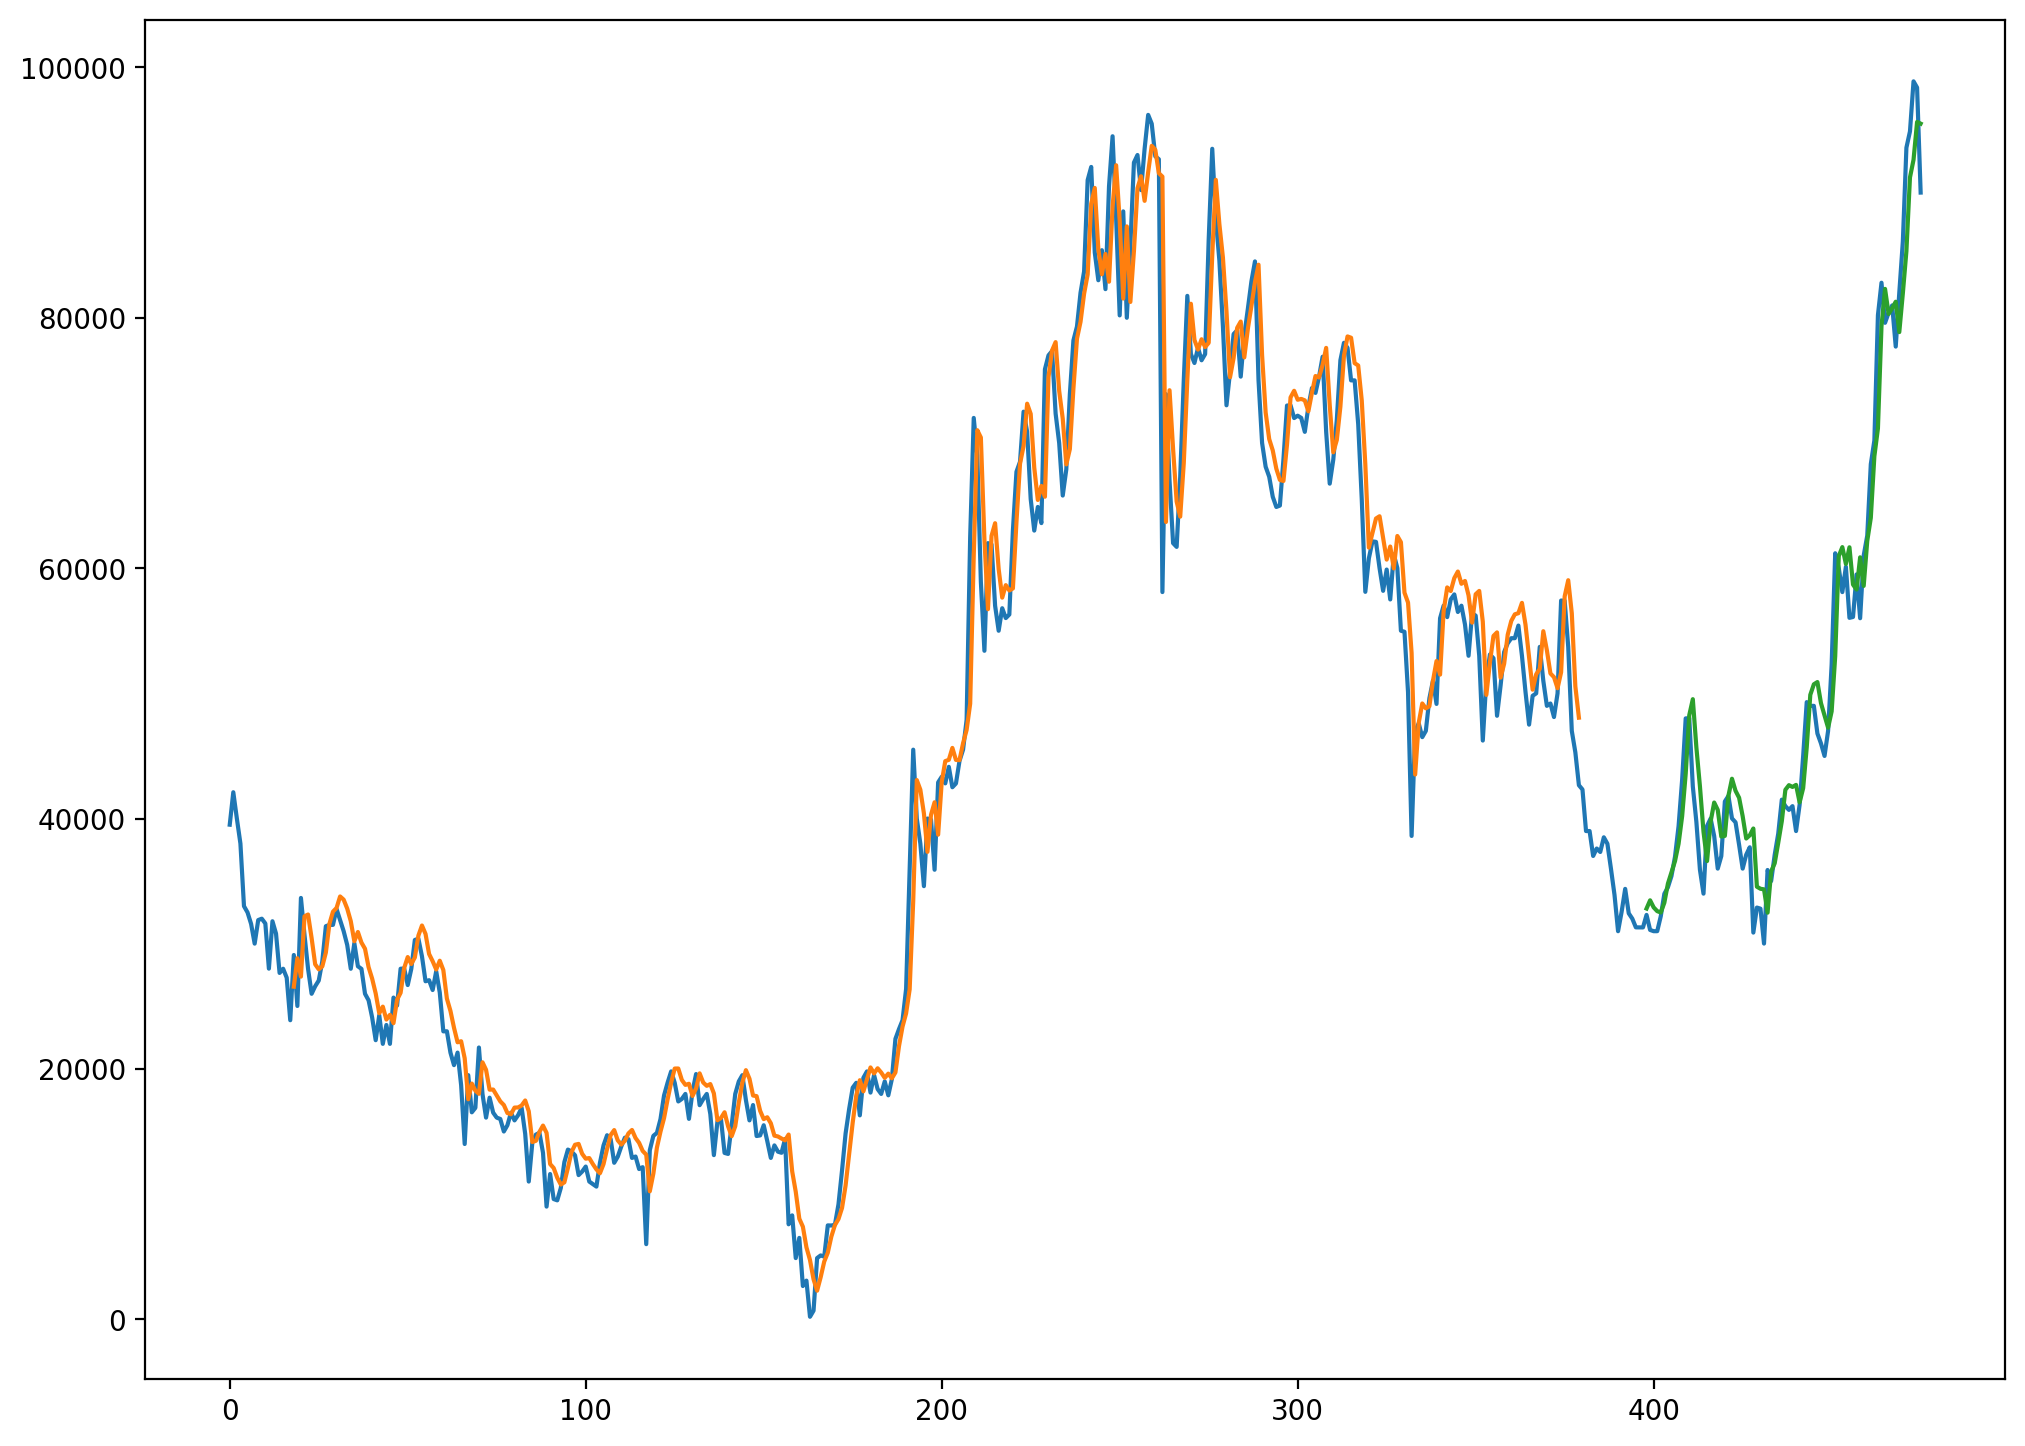

In [13]:
# Creating a plot for the predicted values
plot_predictions(df1, train_predict, test_predict, 18, mm_scaler)

In [14]:
# Calculating the MSE
mean_squared_error(mm_scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict)

12450335.785862409

In [17]:
# Calculating the success rate
success_rate(mm_scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict)

(60.3, 47, 78)

In [19]:
success_with_addition(mm_scaler.inverse_transform(y_test.reshape(-1, 1)), test_predict, 0.90)

(3749, 0.9102564102564102)

## Category E

In [20]:
coe_cat_e = coe[coe['category'] == 'cat_e']
coe_cat_e = coe_cat_e.set_index('new_date')
coe_cat_e.sort_index(inplace=True)

In [21]:
# Scaling the data
mm_scaler2 = MinMaxScaler()
df2 = mm_scaler2.fit_transform(np.array(coe_cat_e['premium']).reshape(-1, 1))

In [22]:
# Creating X and y for both training and test data with 18 timsteps
X_train2, y_train2, X_test2, y_test2 = preprocessing(df2, 18)

In [23]:
# Generating the model
train_predict2, test_predict2 = generate_gru_model(X_train2, y_train2, X_test2, y_test2, mm_scaler2, 18)

Train on 362 samples, validate on 78 samples
Epoch 1/50


2022-05-13 00:52:49.028046: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference___backward_standard_gru_27388_27947' and '__inference___backward_standard_gru_27388_27947_specialized_for_StatefulPartitionedCall_at___inference_distributed_function_29917' both implement 'gru_919e4e87-558a-493e-a69d-c520fda18b42' but their signatures do not match.


352/362 [============================>.] - ETA: 0s - loss: 0.1148 - mae: 0.2680

2022-05-13 00:52:55.660130: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_standard_gru_31403_specialized_for_sequential_1_gru_7_StatefulPartitionedCall_at___inference_distributed_function_31690' and '__inference_cudnn_gru_with_fallback_31492' both implement 'gru_f8a788f4-381b-4551-8535-82714ea76678' but their signatures do not match.


362/362 [==============================] - 12s 33ms/sample - loss: 0.1131 - mae: 0.2659 - val_loss: 0.0243 - val_mae: 0.1391
Epoch 2/50
362/362 [==============================] - 2s 6ms/sample - loss: 0.0242 - mae: 0.1325 - val_loss: 0.0136 - val_mae: 0.0913
Epoch 3/50
362/362 [==============================] - 2s 5ms/sample - loss: 0.0077 - mae: 0.0720 - val_loss: 0.0087 - val_mae: 0.0713
Epoch 4/50
362/362 [==============================] - 2s 7ms/sample - loss: 0.0051 - mae: 0.0515 - val_loss: 0.0084 - val_mae: 0.0697
Epoch 5/50
362/362 [==============================] - 2s 7ms/sample - loss: 0.0049 - mae: 0.0505 - val_loss: 0.0073 - val_mae: 0.0650
Epoch 6/50
362/362 [==============================] - 4s 11ms/sample - loss: 0.0048 - mae: 0.0498 - val_loss: 0.0068 - val_mae: 0.0628
Epoch 7/50
362/362 [==============================] - 4s 12ms/sample - loss: 0.0044 - mae: 0.0487 - val_loss: 0.0073 - val_mae: 0.0640
Epoch 8/50
362/362 [==============================] - 7s 18ms/sample 

2022-05-13 00:58:49.329854: W tensorflow/core/grappler/optimizers/implementation_selector.cc:310] Skipping optimization due to error while loading function libraries: Invalid argument: Functions '__inference_cudnn_gru_with_fallback_37307' and '__inference_standard_gru_37218_specialized_for_sequential_1_gru_6_StatefulPartitionedCall_at___inference_distributed_function_37869' both implement 'gru_9d1e567c-55dd-443b-91c4-90d8afb423d1' but their signatures do not match.


10130623.575596198


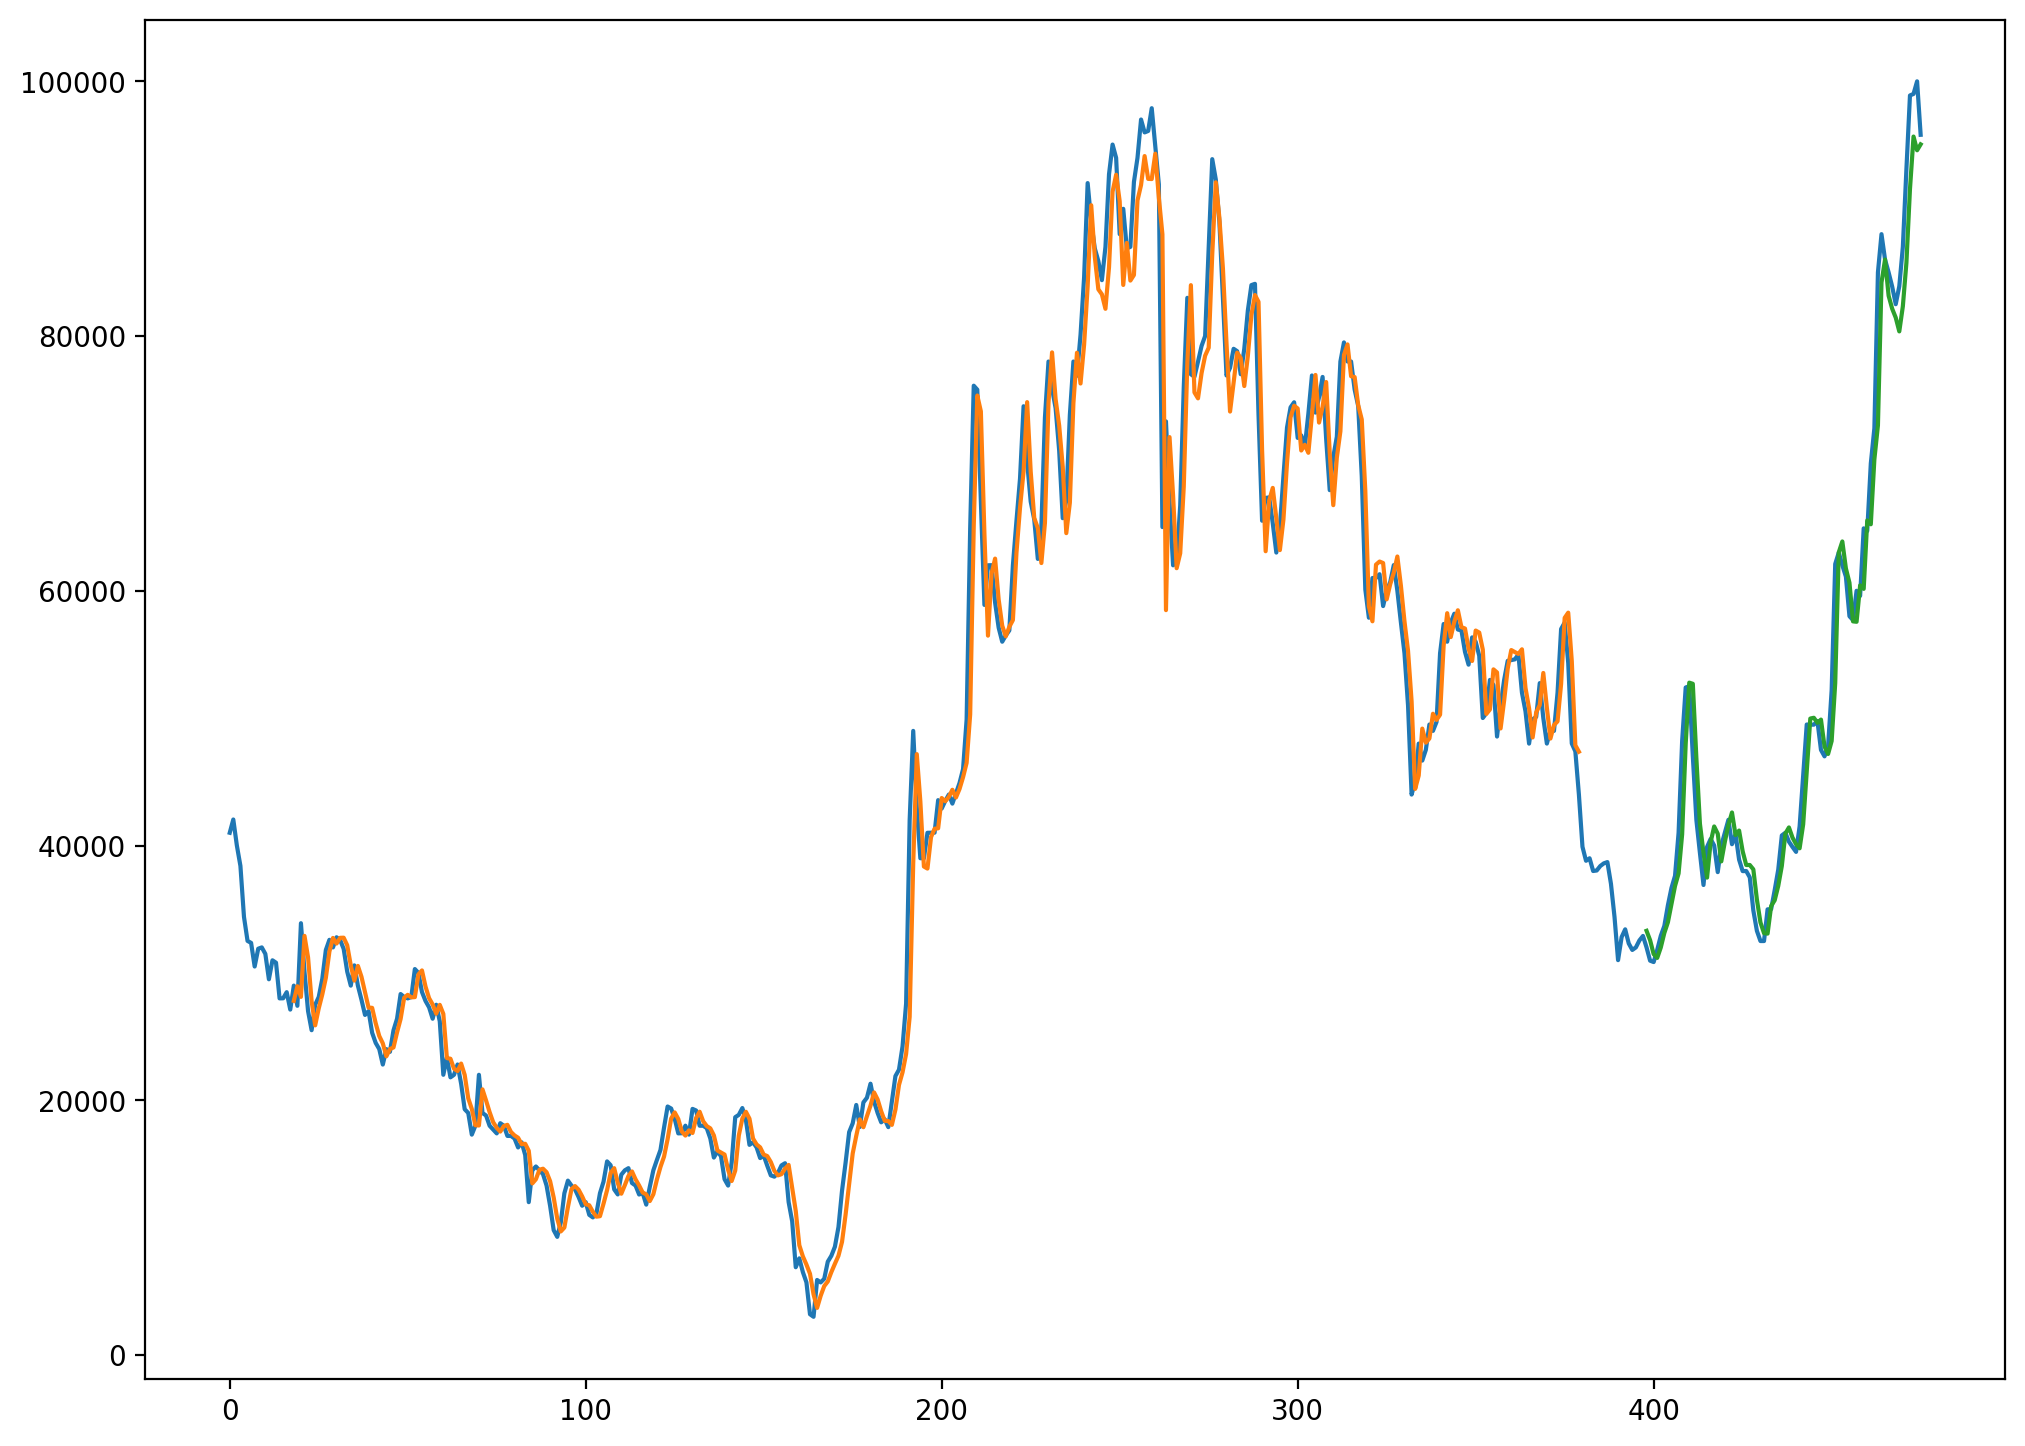

In [24]:
# Creating a plot for the predicted values
plot_predictions(df2, train_predict2, test_predict2, 18, mm_scaler2)

In [25]:
# Calculating the MSE
mean_squared_error(mm_scaler2.inverse_transform(y_test2.reshape(-1, 1)), test_predict2)

10130623.575596198

In [26]:
# Calculating the success rate
success_rate(mm_scaler2.inverse_transform(y_test2.reshape(-1, 1)), test_predict2)

(43.6, 34, 78)

In [27]:
success_with_addition(mm_scaler2.inverse_transform(y_test2.reshape(-1, 1)), test_predict2, 0.90)

(4751, 0.9102564102564102)

## Further Recommendations for other categories

The MSE for the model for category B is 12,450,335 and to get a 90% success rate with the model, there is a need to add $3749 to the prediction.

The MSE for the model for category E is 10,130,623 and to achieve a 90% success rate, there is a need to add $4751 to the prediction.

For both category B and E, the model used had its hyperparameters tuned to the dataset of category A values. In order to make the models even more accurate to each of their own categories, the models should retune their hyperparameters in order to get the best MSE. 

Furthermore, we can retest all the other variables to each model to see if they may improve the model.